<a href="https://colab.research.google.com/github/DyatlovaA/cv-tf/blob/main/CV%26TF_PR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №1 на тему "Классификация изображений машин и самолетов с использованием нейронных сетей"

Выполнили студенты Сухоруков М.С и Дятлова А.А., гр. 6.

## Цель работы

Целью данной практической работы является создание и обучение нейронной сети, способной классифицировать изображения на два класса: машины и самолеты. Мы будем использовать датасет CIFAR-10, который содержит изображения различных объектов, включая автомобили и самолеты. В процессе работы мы реализуем сверточную нейронную сеть (CNN) с использованием библиотеки TensorFlow и оценим её производительность на тестовых данных. Также используем VGG19 для классификации изображений с помощью подхода transfer learning .

## Введение

В данной работе решается задача классификации изображений на два класса: машины и самолеты. Для этого используется датасет CIFAR-10, который содержит 60 000 цветных изображений размером 32x32 пикселя, разделенных на 10 классов. Мы сосредоточимся на двух классах: автомобили (класс 1) и самолеты (класс 0).  Модель будет использовать VGG19 для извлечения признаков из изображений и обучать новые слои для классификации между этими двумя классами.

Для решения задачи будет реализована сверточная нейронная сеть (CNN), которая является эффективным инструментом для работы с изображениями. CNN автоматически извлекает признаки из изображений, что позволяет достичь высокой точности классификации.



#Установим библиотеки:

#Предобработка данных

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle (1).json to kaggle (1).json


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c cifar-10

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

Загрузка данных CIFAR-10

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Нормализация данных (приведение значений пикселей к диапазону [0, 1])

In [ ]:
train_images, test_images = train_images / 255.0, test_images / 255.0

Фильтрация данных для выбора только машин (automobile) и самолетов (airplane)

In [ ]:
def filter_classes(images, labels, class1, class2):
    mask = (labels == class1) | (labels == class2)
    return images[mask.squeeze()], labels[mask.squeeze()]

Классы: airplane (0), automobile (1)

In [ ]:
train_images, train_labels = filter_classes(train_images, train_labels, 0, 1)
test_images, test_labels = filter_classes(test_images, test_labels, 0, 1)

Преобразование меток в бинарные (0 и 1)

In [ ]:
train_labels = np.where(train_labels == 0, 0, 1)
test_labels = np.where(test_labels == 0, 0, 1)

Преобразование меток в одномерный массив

In [ ]:
 train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

Функция для отображения изображений

In [ ]:
def plot_images(images, labels, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])  # Теперь labels[i] будет скаляром
    plt.show()

Визуализация данных (Отображение первых 25 изображений)

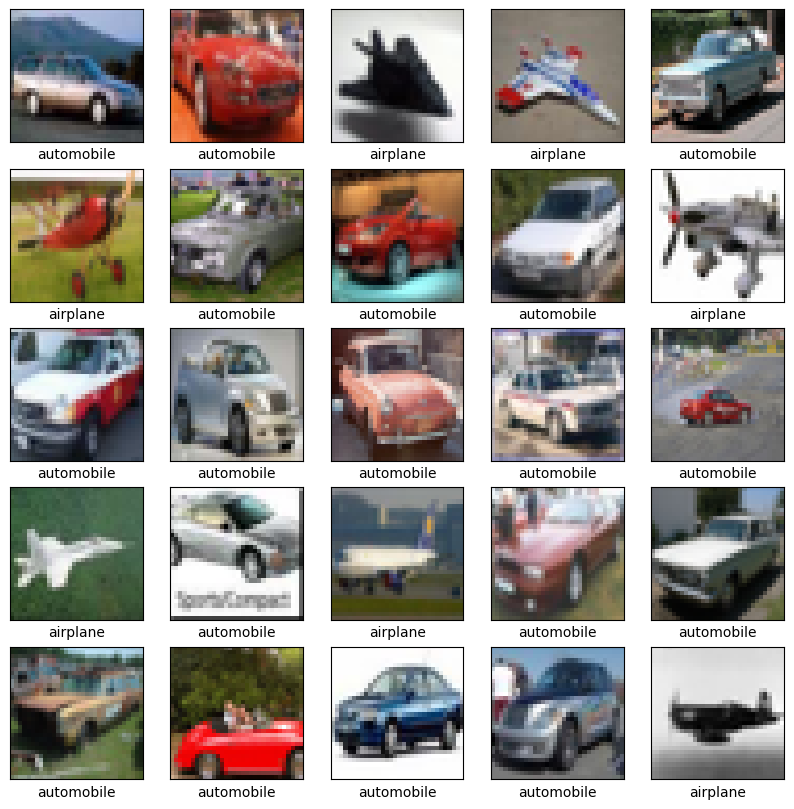

In [ ]:
plot_images(train_images, train_labels, ['airplane', 'automobile'])

Преобразование данных в tf.data.Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

Разделение на батчи и перемешивание

In [ ]:
batch_size = 32
train_dataset = train_dataset.shuffle(len(train_images)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Оптимизация производительности

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Построение модели

Импорт необходимых библиотек


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

Высота и ширина изображений

In [ ]:
img_height = 32  # Высота изображений CIFAR-10
img_width = 32   # Ширина изображений CIFAR-10

Создание модели

In [ ]:
model = Sequential([
    layers.Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(['airplane', 'automobile']), activation='softmax')  # 2 класса
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Вывод структуры модели

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 885,666 (3.38 MB)

 Trainable params: 885,666 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

Компиляция модели

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Обучение модели


In [ ]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - loss: 0.5514 - sparse_categorical_accuracy: 0.6895 - val_loss: 0.2156 - val_sparse_categorical_accuracy: 0.9120
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - loss: 0.2143 - sparse_categorical_accuracy: 0.9158 - val_loss: 0.1557 - val_sparse_categorical_accuracy: 0.9420
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.1314 - val_sparse_categorical_accuracy: 0.9520
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 0.1161 - sparse_categorical_accuracy: 0.9553 - val_loss: 0.1232 - val_sparse_categorical_accuracy: 0.9560
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 0.0897 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.1413 - val_sparse_categorical_accuracy: 0.9465
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.1295 - val_sparse_categorical_accuracy:

Сохранение модели

In [ ]:
model.save('cnn_model.keras')

Функция для построения матрицы ошибок

In [ ]:
def tf_confusion_matrix(model, data_loader, classes):
    matrix = tf.zeros((len(classes), len(classes)), dtype=tf.int32)

    for inputs, labels in data_loader:
        outputs = model.predict(inputs)
        true_class = labels  # Метки уже целочисленные
        predict_class = tf.argmax(outputs, axis=1)
        for t, p in zip(true_class, predict_class):
            matrix = tf.tensor_scatter_nd_add(matrix, [[t, p]], [1])

    print(matrix)

Построение матрицы ошибок

In [ ]:
tf_confusion_matrix(model, test_dataset, ['airplane', 'automobile'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

#Tрансферное обучение

Используем предобученную модель VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

Параметры для VGG19

In [ ]:
img_height = 32  # VGG19 требует изображения размером 224x224
img_width = 32

Изменение размера изображений для VGG19

In [ ]:
train_images_resized = tf.image.resize(train_images, [img_height, img_width])
test_images_resized = tf.image.resize(test_images, [img_height, img_width])

Преобразование данных в tf.data.Dataset для VGG19

In [ ]:
train_dataset_vgg = tf.data.Dataset.from_tensor_slices((train_images_resized, train_labels))
test_dataset_vgg = tf.data.Dataset.from_tensor_slices((test_images_resized, test_labels))

Разделение на батчи и перемешивание

In [ ]:
batch_size = 16
train_dataset_vgg = train_dataset_vgg.shuffle(len(train_images_resized)).batch(batch_size)
test_dataset_vgg = test_dataset_vgg.batch(batch_size)

Оптимизация производительности

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset_vgg = train_dataset_vgg.prefetch(buffer_size=AUTOTUNE)
test_dataset_vgg = test_dataset_vgg.prefetch(buffer_size=AUTOTUNE)

Создание модели VGG19

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Замораживаем слои VGG19

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Создаем новую модель на основе VGG19

In [ ]:
model_vgg = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 класса: airplane и automobile
])

Компиляция модели

In [ ]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Вывод структуры модели

In [ ]:
model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,812,610 (79.39 MB)

 Trainable params: 788,226 (3.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Обучение модели VGG19

In [ ]:
history_vgg = model_vgg.fit(
    train_dataset_vgg,
    validation_data=test_dataset_vgg,
    epochs=5
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 338ms/step - accuracy: 0.8190 - loss: 0.4118 - val_accuracy: 0.9005 - val_loss: 0.2688
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 332ms/step - accuracy: 0.8868 - loss: 0.2641 - val_accuracy: 0.9015 - val_loss: 0.2504
Epoch 3/5
412/625 ━━━━━━━━━━━━━━━━━━━━ 1:00 282ms/step - accuracy: 0.9045 - loss: 0.2460

In [ ]:
model_vgg.save('vgg_model.keras')

Оптимизация производительности

In [ ]:
tf_confusion_matrix(model_vgg, test_dataset_vgg, ['airplane', 'automobile'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
import matplotlib.pyplot as plt

# Извлечение значений потерь и точности
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc_values = history.history['sparse_categorical_accuracy']
val_acc_values = history.history['val_sparse_categorical_accuracy']

epochs = range(1, len(loss_values) + 1)


График потери

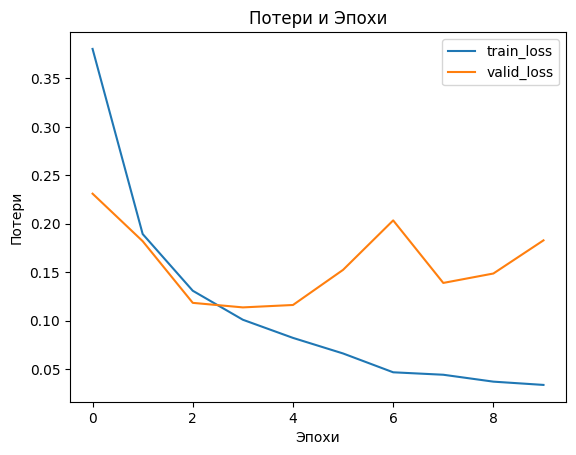

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history_dict['loss'], label='train_loss')
plt.plot(history_dict['val_loss'], label='valid_loss')
plt.title('Потери и Эпохи')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

График точности

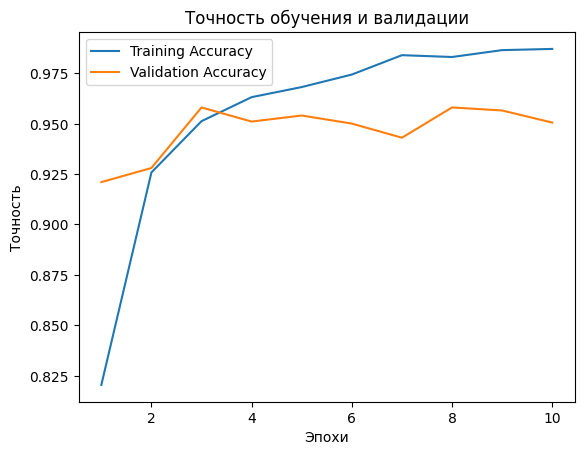

In [ ]:
# График точности
plt.plot(epochs, acc_values, label='Training Accuracy')
plt.plot(epochs, val_acc_values, label='Validation Accuracy')
plt.title('Точность обучения и валидации')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.show()

Определение скорости модели

In [ ]:
start_time = time.time()
model.fit(train_dataset, validation_data=test_dataset, epochs=1)
end_time = time.time()

print(f"FPS: {int(end_time - start_time)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.0281 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.2250 - val_sparse_categorical_accuracy: 0.9390
FPS: 20
